In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]

In [3]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index(drop=True)
keys = excel['Key']
L = get_filename_list(excel['Associated data'])

[3, 9]


In [4]:
x10_x17 = excel.iloc[:, 3:-3]
x10_x17.head()

,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI #,X17: CI
0,A,298.0,0,0,0,7.00,0,N
1,B,298.0,0,0,50,4.74,0,N
2,A,298.0,0,0,0,7.00,1,CI_2
3,A,298.0,0,0,0,7.00,2,CI_1
4,A,298.0,0,0,0,7.00,2,CI_2


In [5]:
master, master_names = prepare_master(x10_x17)

In [6]:
K = master
y = excel['Output: logK']

In [7]:
D = create_x3_matrix(L)

50 50


In [53]:
results = []
for i in range(D.shape[0]):
    mask = np.ones(y.shape, dtype=bool)
    mask[i] = False
    y_train = y[mask]
    y_test = y[i]
    K_train = np.delete(K, i, axis=0)
    K_test = K[i].reshape(1,-1)
    D_train = np.delete(D, i, axis=0)
    D_test = D[i].reshape(1,-1)
    DD_train = np.hstack((D_train, K_train))
    DD_test = np.hstack((D_test, K_test))
    
    DD_train = D_train
    DD_test = D_test
    
#     sws = compute_sample_weights(y_train, lim=3, mul=1)
    
    clf = KernelRidge(kernel='rbf', alpha=1e-10)
#     clf = linear_model.LinearRegression()
#     clf = DecisionTreeRegressor()
#     clf = GaussianProcessRegressor()

#     clf.fit(D_train,y_train)
#     clf = svm.LinearSVR(C=1, epsilon=0.1)
#     clf.fit(DD_train,y_train, sample_weight=sws)
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    results.append({'predicted':prediction[0], 'actual':y_test, 'key':keys[i]})

In [54]:
res_df = pd.DataFrame(results)
print(np.median(np.abs(res_df['predicted'] - res_df['actual'])))
res_df.tail(20)

1.4636441544703818


,actual,key,predicted
176,7.14,199,1.833661
177,6.83,200,1.991573
178,5.95,201,5.600517
179,6.20,202,4.486858
180,5.11,203,4.165873
181,5.93,204,3.529539
182,4.30,207,9.673600
183,9.71,208,4.438900
184,10.78,209,8.485962
185,8.23,210,5.437270


Text(0,0.5,'Predicted logK')

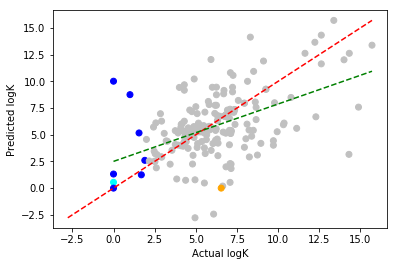

In [55]:
colors = ['cyan' if row['key'] == 217 else 'blue' if (row['actual'] < 2) else 'orange' if row['key'] == 216 else 'silver' for idx, row in res_df.iterrows()]
plt.scatter(res_df['actual'], res_df['predicted'], color=colors)
plt.plot([res_df['predicted'].min(),res_df['predicted'].max()],[res_df['predicted'].min(),res_df['predicted'].max()], 'r--')
plt.plot(np.unique(res_df['actual']), np.poly1d(np.polyfit(res_df['actual'], res_df['predicted'], 1))(np.unique(res_df['actual'])), 'g--')
plt.xlabel('Actual logK')
plt.ylabel('Predicted logK')